In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import os
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

log_pattern = re.compile(
    r"INFO\s- EVENT:\s(?P<event_type>[A-Za-z\s]+)\s\| "
    r"(?:SENDER:\s(?P<sender>\d+)\s\| )?"
    r"(?:RECIPIENT:\s(?P<recipient>\d+)\s\| )?"
    r"LOGICAL TIME:\s(?P<logical_time>\d+)\s\| "
    r"PHYSICAL TIME:\s(?P<physical_time>[0-9-]+\s[0-9:.]+), "
    r"MESSAGE QUEUE LENGTH:\s(?P<queue_size>\d+)"
)

clock_rate_pattern = re.compile(
    r"INFO\s- Clock rate for client (?P<client>\d+): (?P<clock_rate>\d+) events per second"
)

def parse_log_file(file_path):
    data = []
    clock_rates = {}
    with open(file_path, "r") as file:
        for line in file:
            match = log_pattern.search(line)
            if match:
                event_data = match.groupdict()
                # Assign recipient where available, else None
                event_data["recipient"] = event_data["recipient"] if "recipient" in event_data else None
                event_data["sender"] = event_data["sender"] or -1  # Assign -1 if missing
                data.append(event_data)
            clock_rate_match = clock_rate_pattern.search(line)
            if clock_rate_match:
                client = clock_rate_match.group("client")
                clock_rate = int(clock_rate_match.group("clock_rate"))
                experiment_name = os.path.basename(os.path.dirname(file_path))
                if experiment_name not in clock_rates:
                    clock_rates[experiment_name] = {}

                clock_rates[experiment_name][client] = clock_rate

    if not data:
        return pd.DataFrame(), clock_rates

    df = pd.DataFrame(data)
    
    # Convert to correct data types
    df["physical_time"] = pd.to_datetime(df["physical_time"])
    df["logical_time"] = df["logical_time"].astype(int)
    df["queue_size"] = df["queue_size"].astype(int)
    df["sender"] = df["sender"].astype(int)
    df["recipient"] = df["recipient"].astype(float).astype("Int64")  # Keep as nullable integer

    # Extract experiment name and client number
    experiment_name = os.path.basename(os.path.dirname(file_path))
    client_name = os.path.basename(file_path).split("_")[1]
    df["experiment"] = experiment_name
    df["client"] = client_name
    
    return df, clock_rates

log_files = glob.glob(os.path.join("experiment*/client_*_events.log"))
dfs = []
clock_rates = {}
for file in log_files:
    df, rates = parse_log_file(file)
    dfs.append(df)
    for experiment, clients in rates.items():
        if experiment not in clock_rates:
            clock_rates[experiment] = {}
        clock_rates[experiment].update(clients)
    clock_rates.update(rates)

df = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

experiments_fixed = df["experiment"].unique()

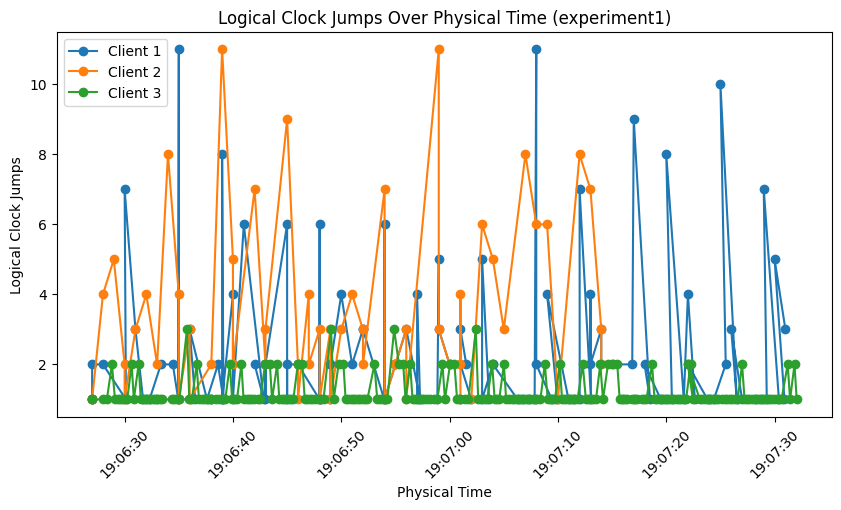

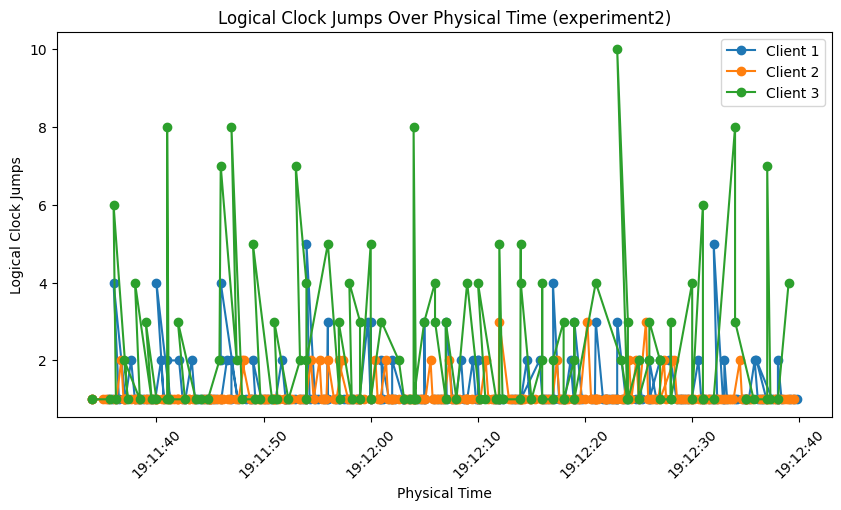

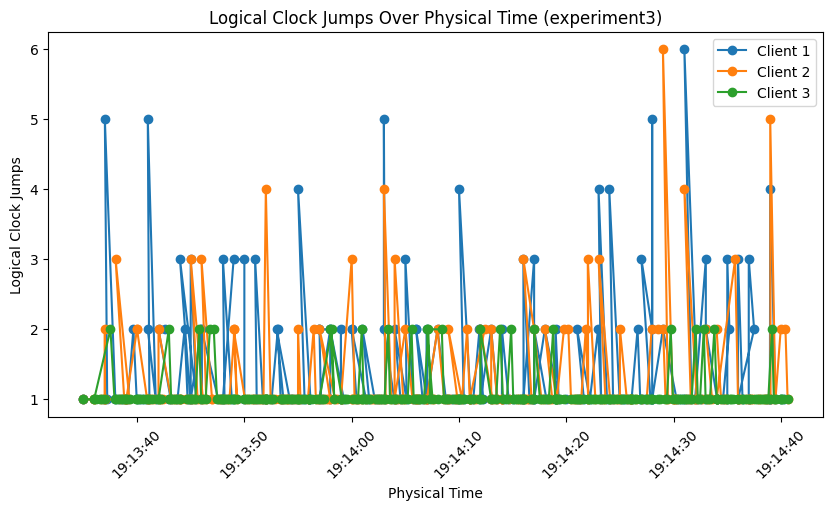

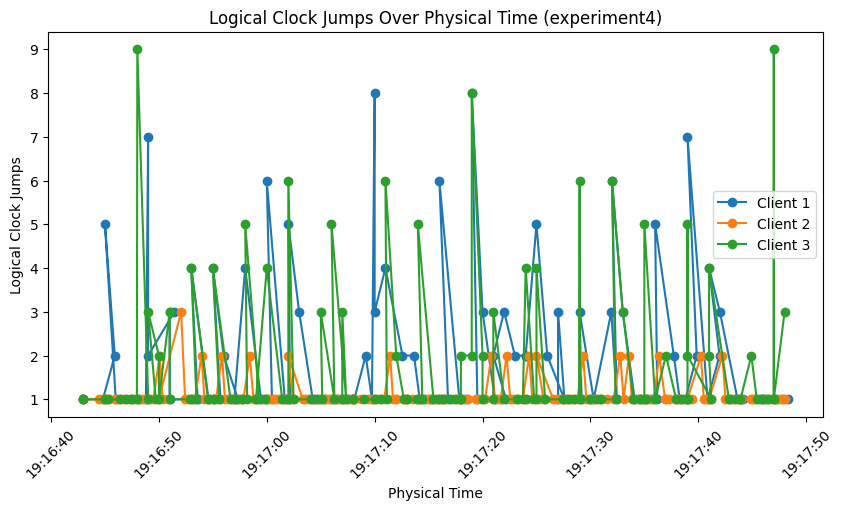

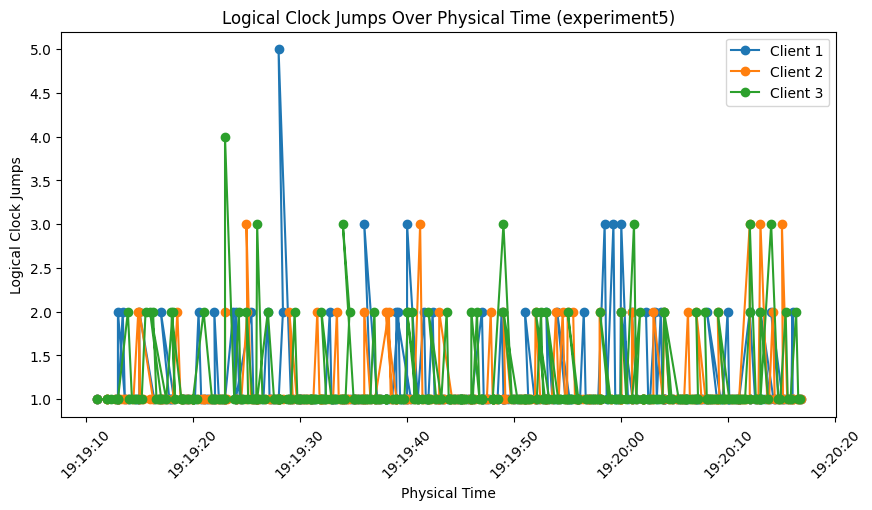

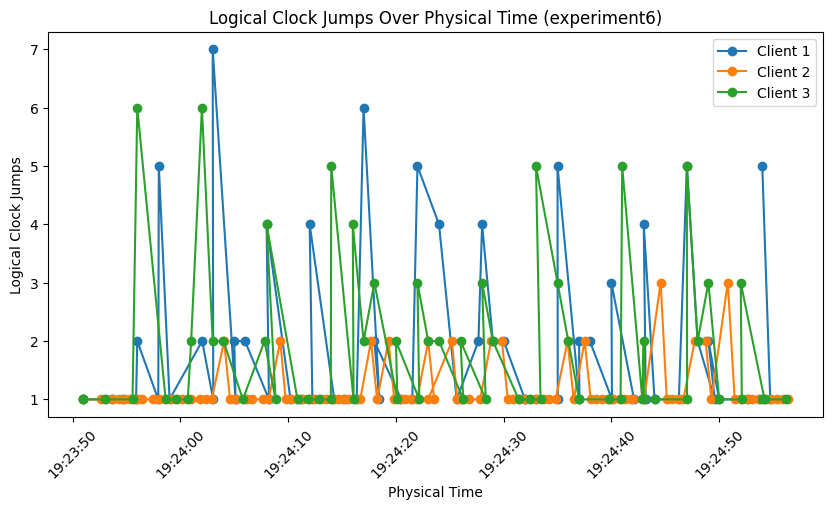

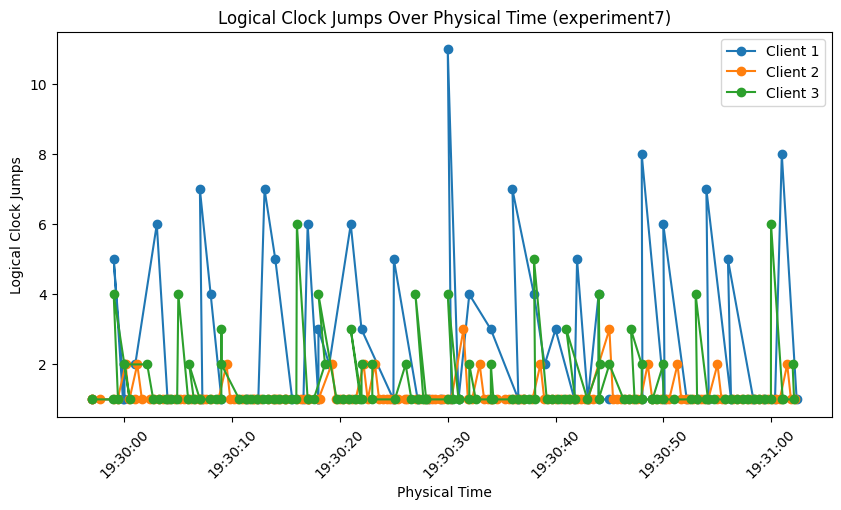

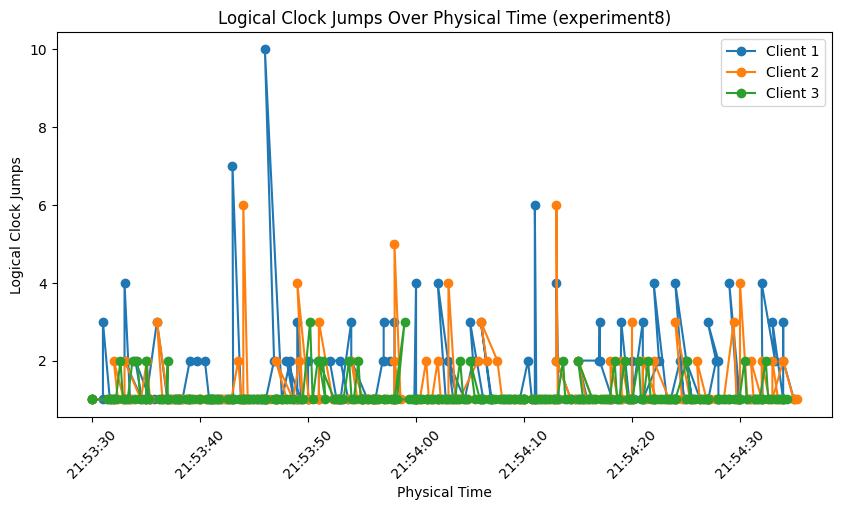

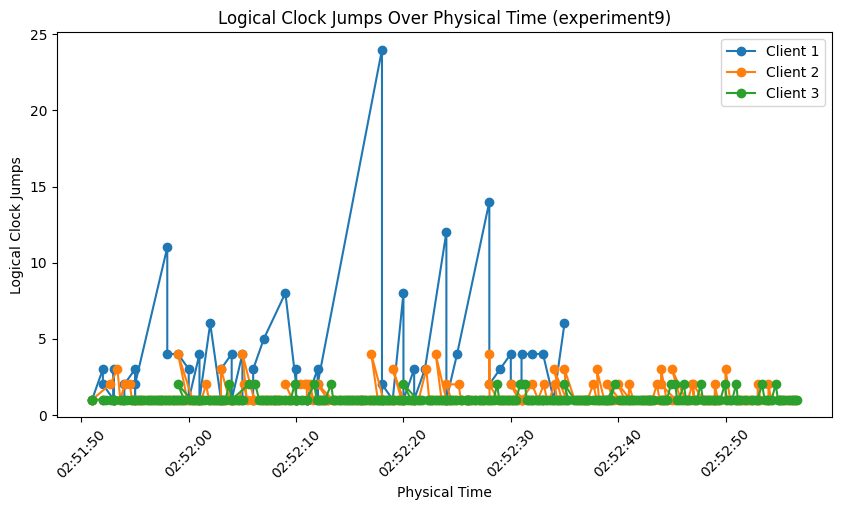

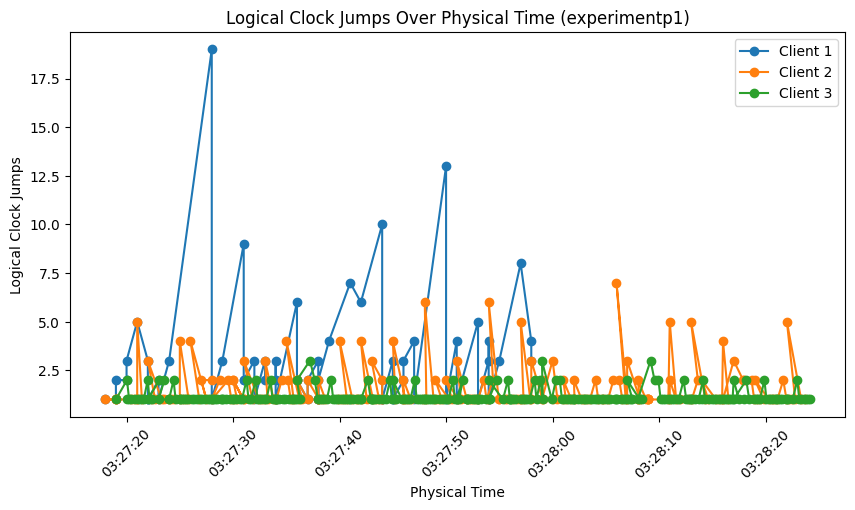

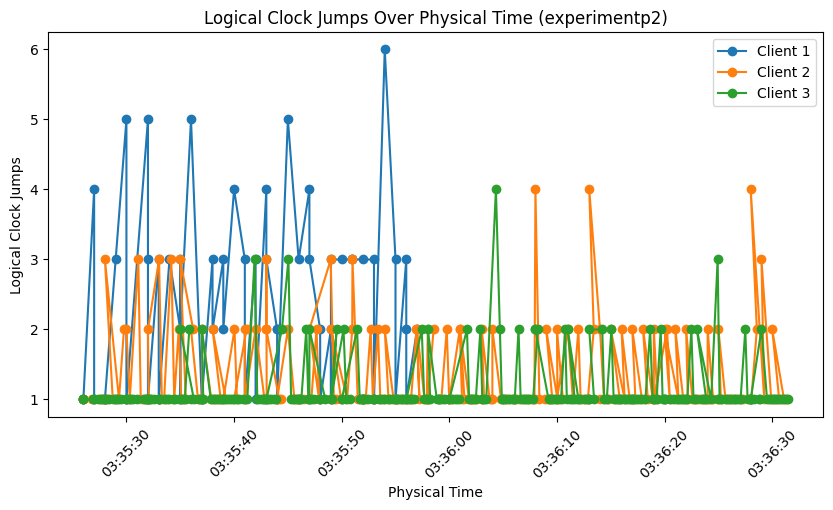

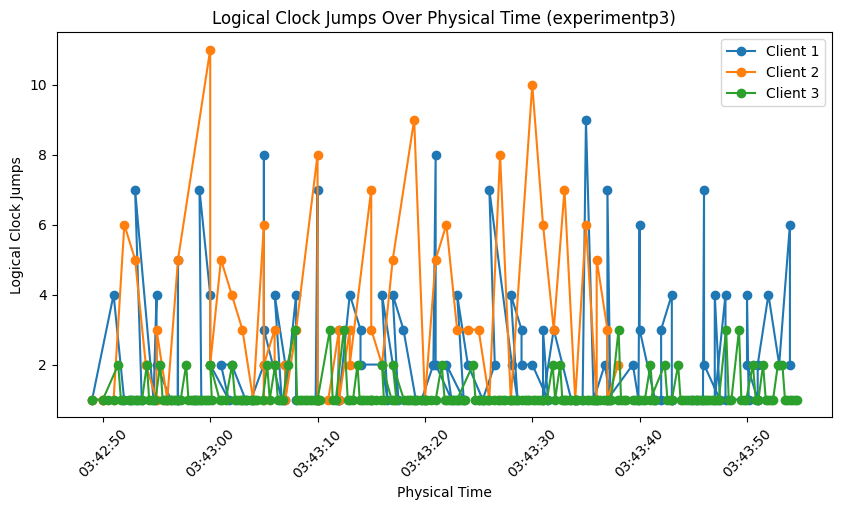

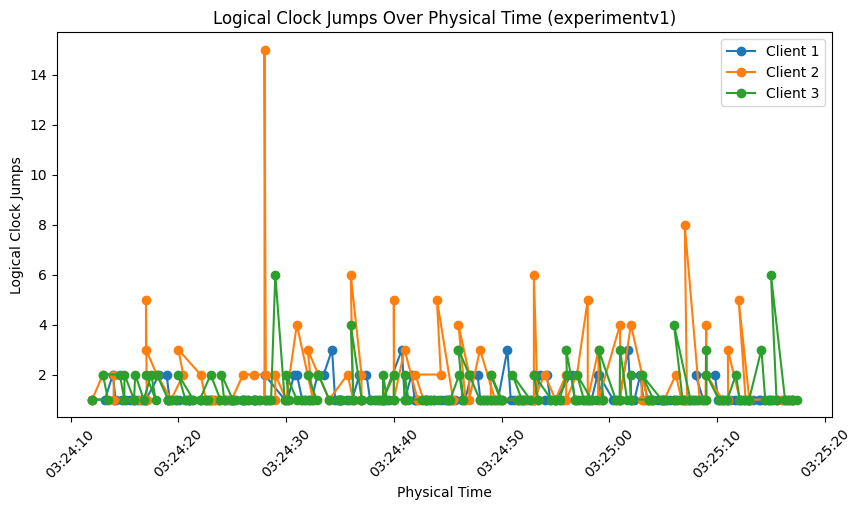

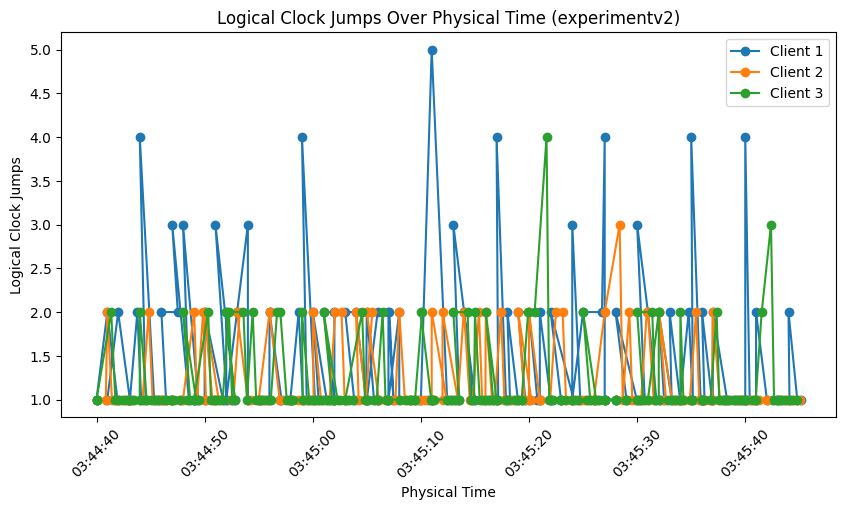

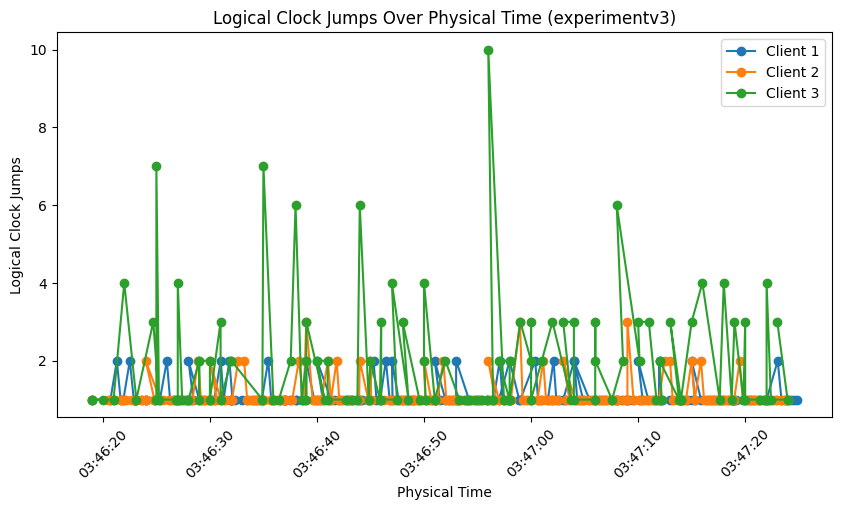

In [ ]:
# Physical time vs logical clock jumps
for experiment in experiments_fixed:
    exp_df = df[df["experiment"] == experiment].copy()
    
    # Compute logical clock jumps per experiment separately
    exp_df["logical_jump"] = exp_df.groupby("client")["logical_time"].diff()
    
    # Generate plot for this experiment
    plt.figure(figsize=(10, 5))
    for client in exp_df["client"].unique():
        subset = exp_df[exp_df["client"] == client]
        plt.plot(subset["physical_time"], subset["logical_jump"], marker="o", linestyle="-", label=f"Client {client} (Clock Rate)")
    
    plt.xlabel("Physical Time")
    plt.ylabel("Logical Clock Jumps")
    plt.title(f"Logical Clock Jumps Over Physical Time ({experiment})")
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

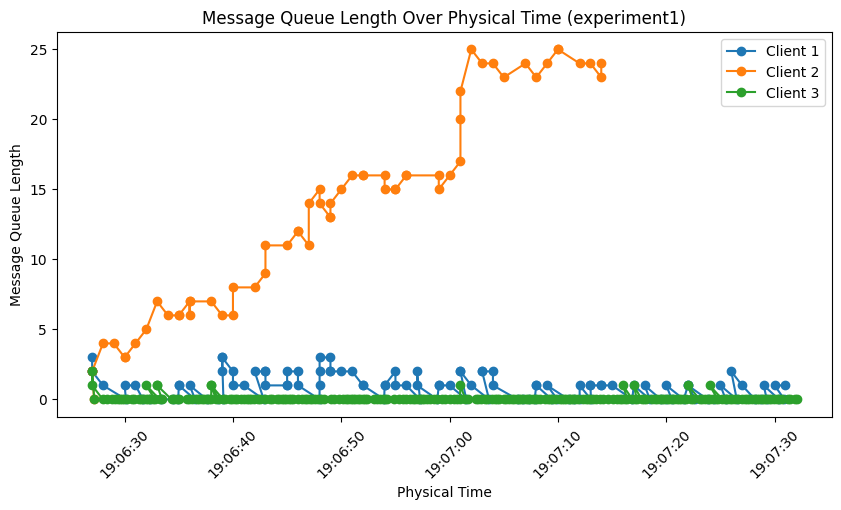

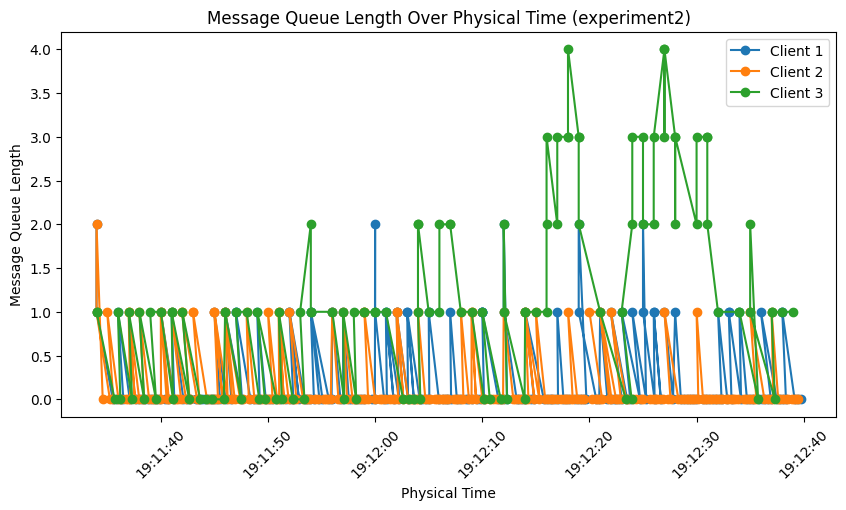

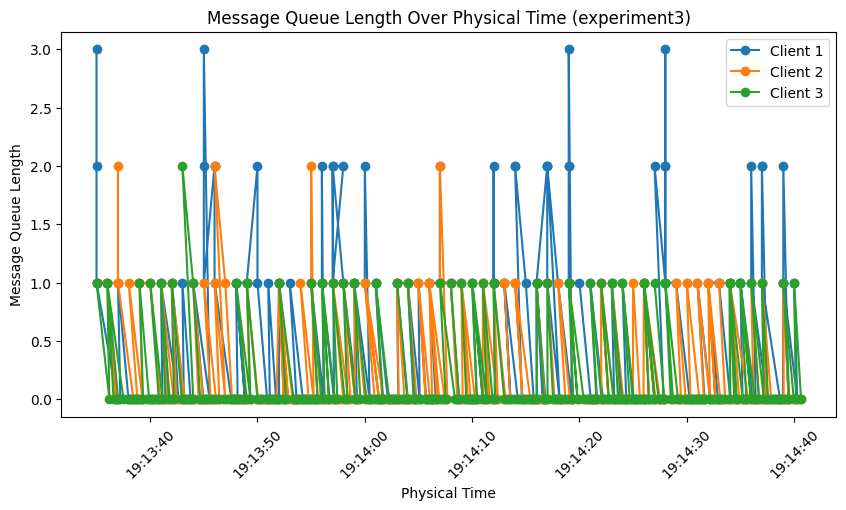

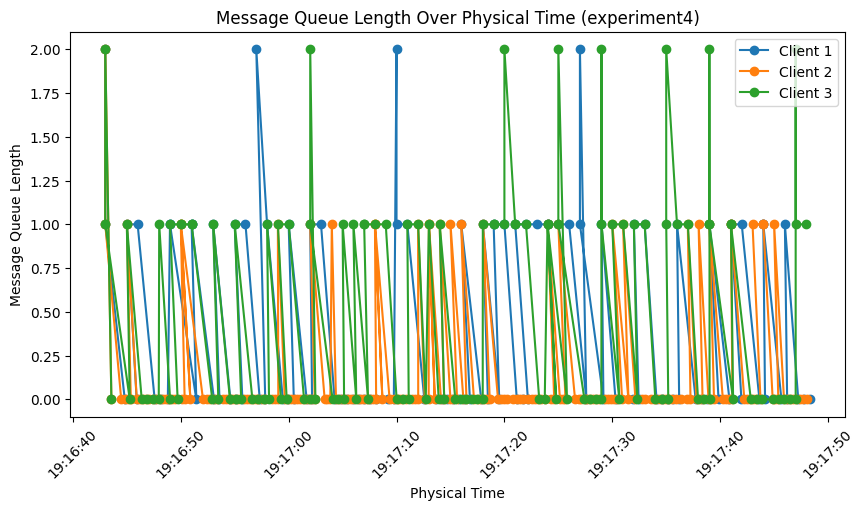

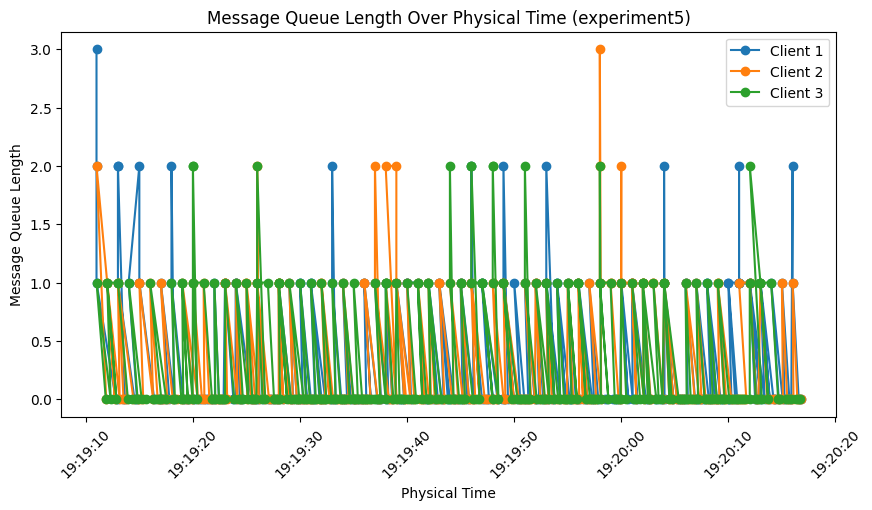

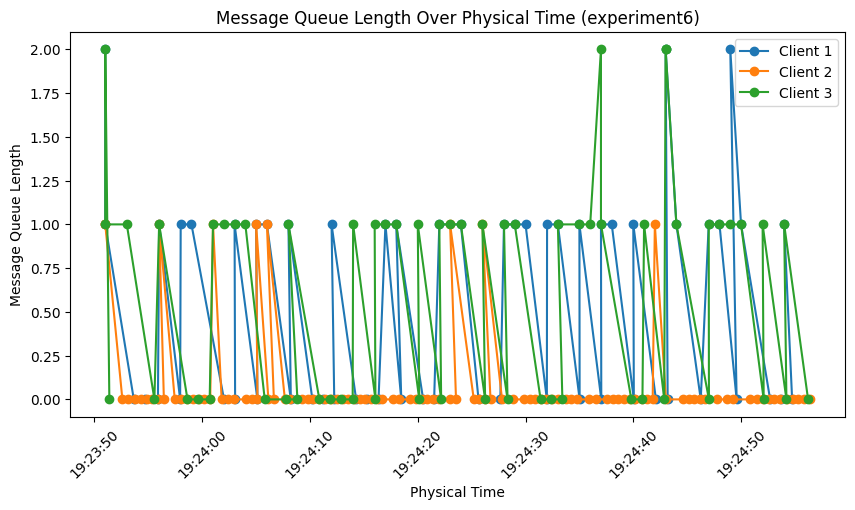

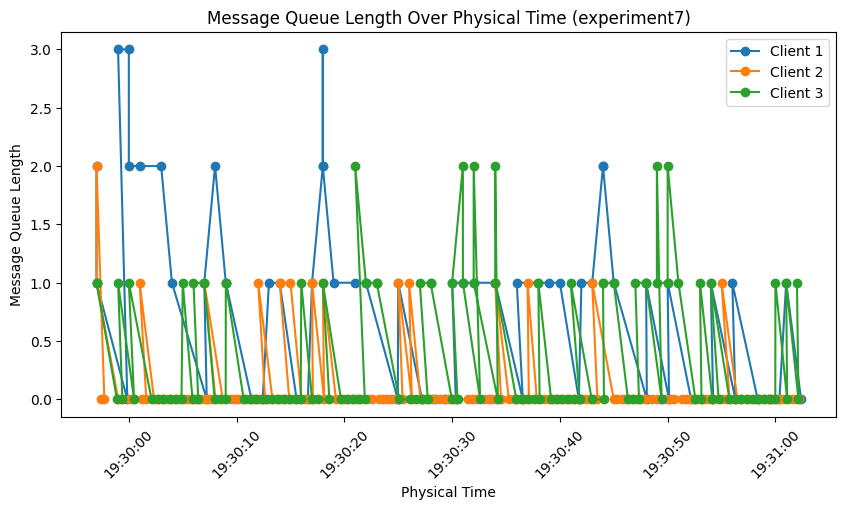

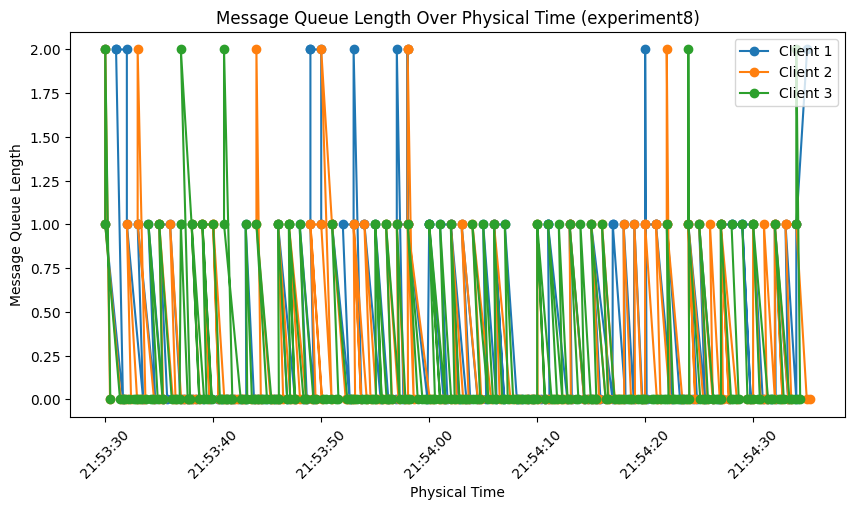

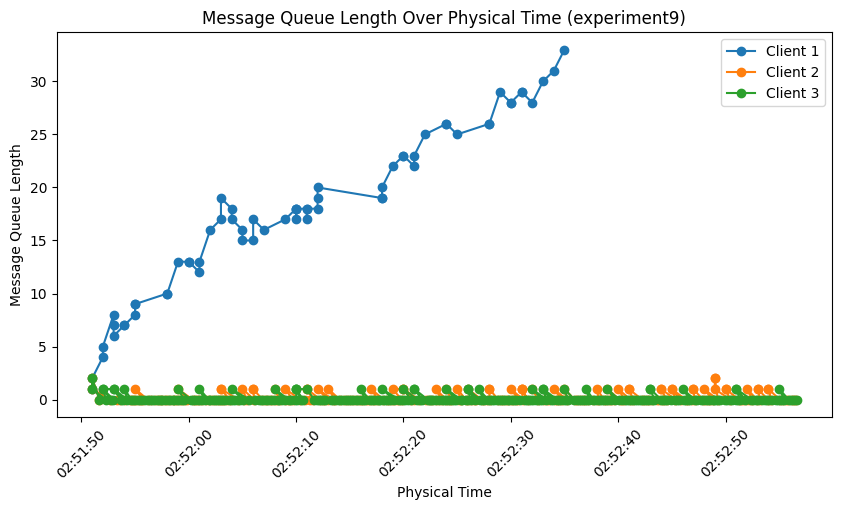

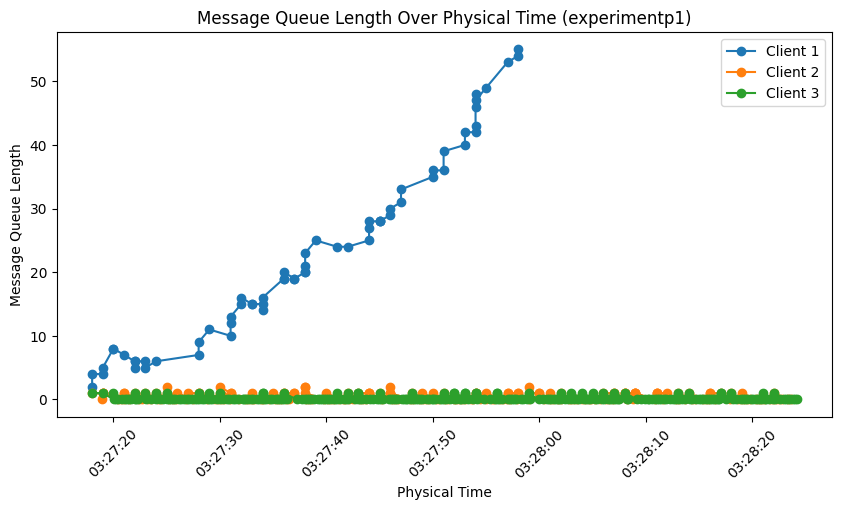

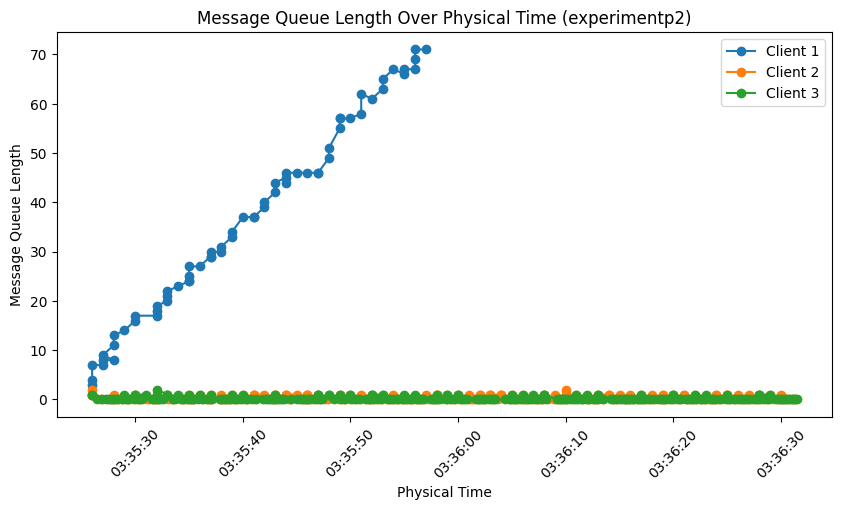

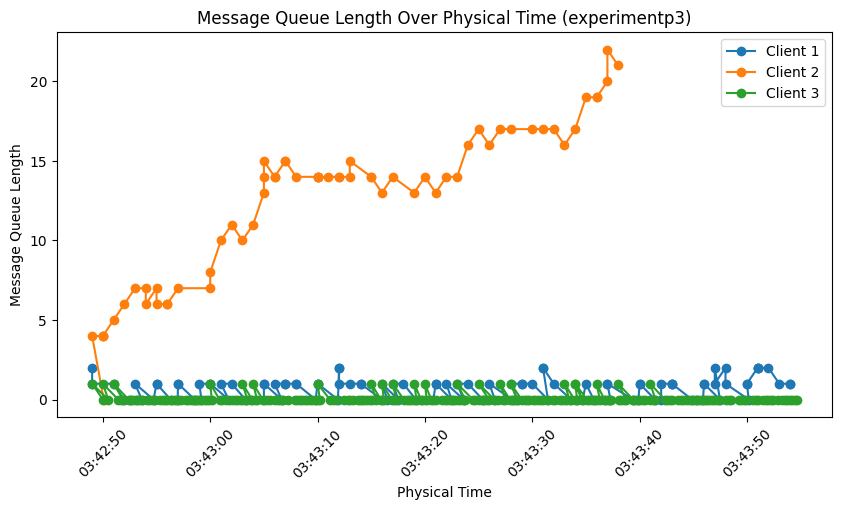

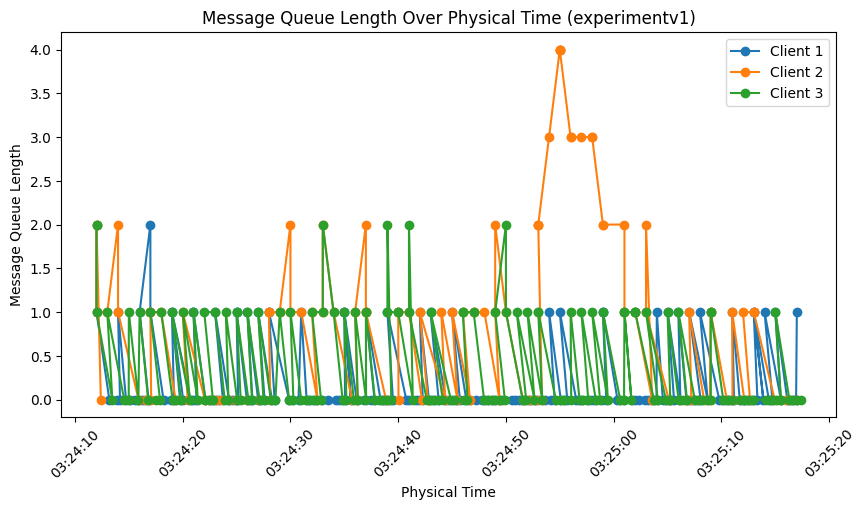

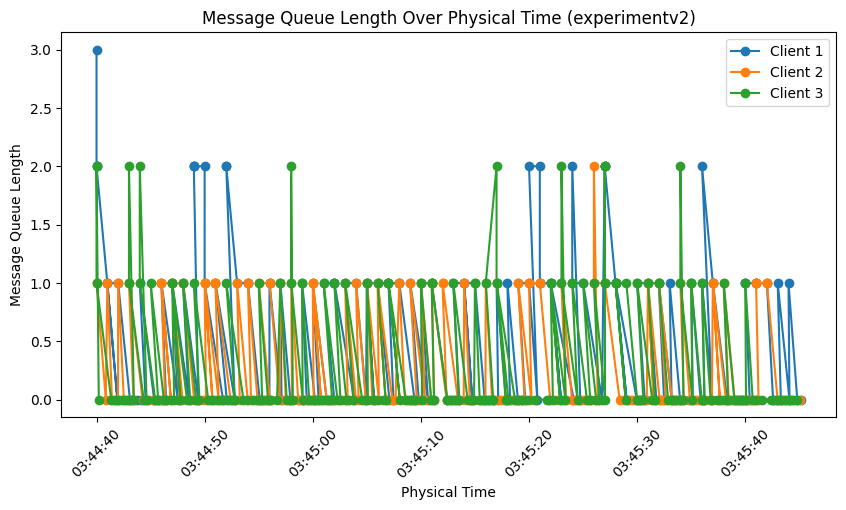

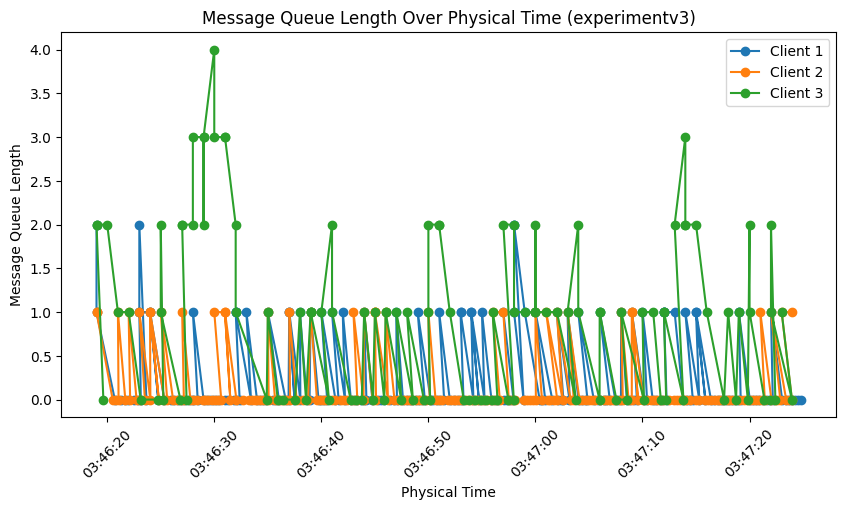

In [99]:
for experiment in experiments_fixed:
    exp_df = df[df["experiment"] == experiment].copy()
    
    # Generate plot for message queue length over physical time
    plt.figure(figsize=(10, 5))
    for client in exp_df["client"].unique():
        subset = exp_df[exp_df["client"] == client]
        plt.plot(subset["physical_time"], subset["queue_size"], marker="o", linestyle="-", label=f"Client {client}")
    
    plt.xlabel("Physical Time")
    plt.ylabel("Message Queue Length")
    plt.title(f"Message Queue Length Over Physical Time ({experiment})")
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

In [103]:
import pandas as pd
import numpy as np

# Dictionary to store summary statistics for all experiments
summary_stats = []

# Process each experiment separately
for experiment in df["experiment"].unique():
    exp_df = df[df["experiment"] == experiment].copy()
    
    # Logical clock jumps statistics
    exp_df["logical_jump"] = exp_df.groupby("client")["logical_time"].diff()
    
    logical_jump_stats = exp_df.groupby("client")["logical_jump"].agg(
        ["mean", "std", "max"]
    ).reset_index()
    logical_jump_stats["experiment"] = experiment
    logical_jump_stats = logical_jump_stats.rename(columns={
        "mean": "logical_jump_mean",
        "std": "logical_jump_std",
        "max": "logical_jump_max"
    })
    
    # Logical clock drift statistics (final - initial logical time)
    drift_stats = exp_df.groupby("client")["logical_time"].agg(
        ["first", "last"]
    ).reset_index()
    drift_stats["logical_clock_drift"] = drift_stats["last"] - drift_stats["first"]
    drift_stats["experiment"] = experiment
    
    # Gaps in logical clock values (count instances of non-sequential logical time jumps)
    exp_df["logical_time_gap"] = exp_df.groupby("client")["logical_time"].diff().fillna(0)
    gaps_stats = exp_df[exp_df["logical_time_gap"] > 1].groupby("client")["logical_time_gap"].count().reset_index()
    gaps_stats["experiment"] = experiment
    gaps_stats = gaps_stats.rename(columns={"logical_time_gap": "num_gaps_in_logical_time"})
    
    # Message queue length statistics
    queue_stats = exp_df.groupby("client")["queue_size"].agg(
        ["mean", "std", "max"]
    ).reset_index()
    queue_stats["experiment"] = experiment
    queue_stats = queue_stats.rename(columns={
        "mean": "queue_mean_length",
        "std": "queue_std_length",
        "max": "queue_max_length"
    })
    
    # Merge all statistics into a single dataframe
    exp_summary = logical_jump_stats.merge(drift_stats, on=["client", "experiment"])
    exp_summary = exp_summary.merge(gaps_stats, on=["client", "experiment"], how="left").fillna(0)
    exp_summary = exp_summary.merge(queue_stats, on=["client", "experiment"])

    exp_summary["clock_rate"] = exp_summary["client"].map(clock_rates)
    
    # Append results to summary list
    summary_stats.append(exp_summary)

# Combine all experiment summaries into a single DataFrame
df_summary = pd.concat(summary_stats, ignore_index=True)

# Display summary statistics
df_summary

,client,logical_jump_mean,logical_jump_std,logical_jump_max,experiment,first,last,logical_clock_drift,num_gaps_in_logical_time,queue_mean_length,queue_std_length,queue_max_length,clock_rate
0,1,2.473684,2.254633,11.0,experiment1,1,283,282,61,0.913043,0.864152,3,4
1,2,3.409836,2.577965,11.0,experiment1,1,209,208,45,13.387097,7.300022,25,4
2,3,1.179167,0.425622,3.0,experiment1,1,284,283,39,0.053942,0.244086,2,2
3,1,1.306604,0.718974,5.0,experiment2,1,278,277,43,0.291080,0.504475,2,4
4,2,1.099206,0.337083,3.0,experiment2,1,278,277,22,0.185771,0.399746,2,4
5,3,2.421053,2.012768,10.0,experiment2,1,277,276,55,1.200000,1.077684,4,2
6,1,1.492823,0.925699,6.0,experiment3,1,313,312,63,0.614286,0.775699,3,4
7,2,1.263158,0.686379,6.0,experiment3,2,314,312,43,0.318548,0.500343,2,4
8,3,1.079038,0.270263,2.0,experiment3,1,315,314,23,0.205479,0.413148,2,2
9,1,2.018868,1.695828,8.0,experiment4,1,215,214,41,0.429907,0.568217,2,4
